# Introduction to Raster Data Analysis in Python

This notebook is part of the **Programación SIG** course, taught within the **Master's in Geomatics** programme at the **Faculty of Agricultural Sciences**,  
**Universidad Nacional de Colombia**.

**Lecturer:** Liliana Carolina Castillo Villamor  

## 0. Introduction
Working with raster data in Python can be approached using several libraries, but two stand out as the most prominent: **`rasterio`** and **`rioxarray`**.

Although both libraries allow you to read, write, and manipulate raster data, they differ in the way they represent and organise the data:

- **`rasterio`** is a well-established, lower-level library. It loads raster data as **NumPy arrays**, while storing spatial information (like coordinate reference systems, resolution, and extent) in a **separate object**. This design offers a lot of flexibility and control, but it also means you need to manage more details manually.

- **`rioxarray`** is a **wrapper** around `rasterio`. That means it uses `rasterio` behind the scenes, but presents the raster data in a more user-friendly format. Specifically, it leverages **`xarray`**, a library that extends NumPy arrays by allowing them to include labels for axes (e.g. bands, time, x, y) and attributes all within the same object. This makes it easier to work with multi-dimensional raster data and maintain metadata without having to handle multiple separate objects.

*A wrapper is like a friendly interface that simplifies the use of another tool. `rioxarray` wraps around `rasterio` to make certain tasks easier and more intuitive, while still relying on the robust functionality of `rasterio` underneath.*

Other libraries such as `xarray-spatial` and `geowombat` also follow similar approaches, but are less widely used.

It is important to note that, unlike `geopandas` for vector data (which offers an all-in-one solution), these raster libraries are **not exhaustive**. For example:
- If you need to calculate **zonal statistics**, you might use the `rasterstats` package.
- If you want to derive **topographic indices**, you could rely on the `richdem` package.

In this notebook, we will focus on **`rasterio`** as our main tool for raster data handling. It is powerful, widely supported, and forms a solid foundation for learning how raster data works in Python. In the following sections, you will learn how to read raster files, explore their metadata, and manipulate raster bands using NumPy.
> 📚 *This notebook was developed based on the concepts and guidelines presented in* [*Chapter 1 – Spatial data*](https://py.geocompx.org/01-spatial-data#sec-raster-data) *from the book* **Geocomputation with Python** *by Lovelace, Nowosad, and Muenchow (2022).*



## 1. Setting the scene

### 1.1. Import required libraries

In [1]:
import ee                     # Earth Engine Python AP: provides access to Google's geospatial datasets and analysis capabilities
import geemap                 # simplifies interaction with Earth Engine and allows exporting of raster images
import geopandas as gpd       # used to handle shapefiles and other vector spatial data in Python
import numpy as np
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt  # Library for creating visualisations

### 1.2.Define paths to datasets

In [2]:
m_root=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres/Datos"
aoi=m_root+r"/aoi.gpkg"
dem_path=m_root+"/dem_aoi.tif"

## 2. Downloading a DEM from GEE
The following chunkse demonstrates how to download a DEM clipped to a specific area of interest (AOI), defined by a shapefile, using the Earth Engine Python API.



### 2.1. Earth Engine authentication 
Before accessing Earth Engine, we must authorise the session. This only needs to be done once per environment.

In [20]:

# 3. Authenticate 
ee.Authenticate()


In [5]:
ee.Initialize()

Use shapefile to define the **Area of Interest (AOI)** and extract elevation data specifically for that region. 

In [7]:
# Read the shapefile containing the extent of the study area
gdf_aoi = gpd.read_file(aoi)


#--- Convert the AOI geometry to Earth Engine format ---

aoi_geom = gdf_aoi.geometry[0]                    # Extract the polygon geometry
aoi_coords = aoi_geom.__geo_interface__       # Convert to GeoJSON format
aoi_ee = ee.Geometry(aoi_coords)              # Convert to Earth Engine Geometry

# --  Load the DEM and clip it to the AOI ---

# Use the SRTM DEM (30m resolution) provided by the USGS
dem = ee.Image("USGS/SRTMGL1_003")

# Clip the DEM to the area of interest
dem_clipped = dem.clip(aoi_ee)

# === 4. Export the clipped DEM to a GeoTIFF file on your local computer ===

# Export settings:
# - scale: 30 metres
# - region: defined by AOI
# - file_per_band=False: saves as a single-band GeoTIFF file

geemap.ee_export_image(
    dem_clipped,
    filename=dem_path,
    scale=30,
    region=aoi_ee,
    file_per_band=False
)

print(" Export complete: dem_area_estudio.tif")

Generating URL ...
Please wait ...
Data downloaded to /Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres/Datos/dem_aoi.tif
 Export complete: dem_area_estudio.tif


### 3. Reading a  raster file using rasterio

The function `rasterio.open()` creates a connection to a raster file, allowing us to interact with both the **metadata** and the **pixel values** it contains. This connection allow to extract information such as the number of bands, spatial resolution, coordinate reference system (CRS), and dimensions of the image. At the same time, it enables reading the actual raster data into NumPy arrays for visualisation or further analysis.

The diagram below illustrates how we can use `.meta` to access metadata (returned as a Python dictionary), and `.read()` to extract the raster values, either all bands or specific layers by index.

![Reading raster data](Datos/rasterio-structure.svg)
Open the raster using rasterio (the raster data is stored within numpy arrays). Since we imported earlier the numpy package all its functions are accessible for effective data manipulation.

In [18]:
src_dem = rasterio.open(dem_path)
src_dem 

<open DatasetReader name='/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres/Datos/dem_aoi.tif' mode='r'>

## 4. Explore the raster data
### 4.1. Quick raster visualisation using `rasterio.plot.show()`


Before diving into detailed statistics or custom plots, it is often useful to quickly visualise the raster to confirm that it loads correctly and has valid data.

The function `rasterio.plot.show()` provides a simple and effective way to display a raster image. By default, it shows the first band using a greyscale colour scheme. This is a useful starting point to check the spatial extent, contrast, and general appearance of the raster.

In the example below, we assume the raster has already been opened with `rasterio.open(...)` and stored in the variable `src_dem`.

This approach is convenient for quick checks and initial exploration.


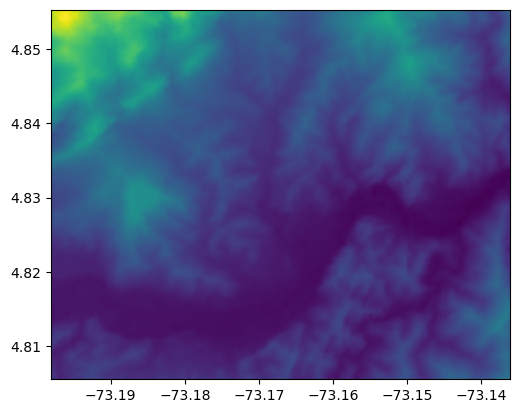

In [65]:
rasterio.plot.show(src_dem);

### 4.2 Reading raster values from the file

The .read() method is used to extract the actual raster values from the file connection object (DatasetReader).

In the following chunk, we are reading the first (and only) band/layer of the raster file. Remember that unlike standard Python indexing, raster bands start from index 1 (not 0)



In [116]:
band1 = src_dem.read(1)  # Read the first layer as a 2D numpy array (rows x columns)

# Check the shape and type of the result
print("Array shape (rows, cols):", band1.shape)
print("Array data type:", band1.dtype)
print("Array ", band1)

Array shape (rows, cols): (185, 230)
Array data type: int16
Array  [[1015 1029 1035 ...  561  584  603]
 [1012 1029 1046 ...  557  574  587]
 [1006 1025 1043 ...  543  561  576]
 ...
 [ 456  448  441 ...  611  613  610]
 [ 459  451  444 ...  616  618  616]
 [ 462  452  443 ...  621  622  623]]


### 4.3. Summary statistics and visualisation

In this section, we explore a Digital Elevation Model (DEM) using the `rasterio` library. The code performs several tasks:

- It opens the raster file from the specified path (`dem_path`).
- It reads the first band (which contains elevation values).
- It prints basic metadata: raster dimensions, number of bands, spatial resolution, CRS, data type, and min/max elevation.
- It visualises the distribution of elevation values using a histogram.
- It displays a simple map of the DEM using a colour scale (`terrain`).

We use the `with rasterio.open(...) as src:` context manager to open the file. This approach is recommended because it **automatically handles the opening and closing of the file**. When the block ends, Python will automatically close the file even if an error occurs inside the block. This prevents memory leaks or file-locking issues and is considered good practice for working with files.

If you use `rasterio.open(...)` without `with`, you must remember to manually close the file later using `src.close()`.

This block gives us a first look at the contents and structure of our raster, and helps identify potential issues such as missing values or extreme outliers.


Raster dimensions (rows, cols): (185, 230)
Number of bands: 1
Coordinate reference system (CRS): EPSG:4326
Resolution (pixel size): (0.0002694945852358564, 0.0002694945852358564)
Data type: int16
Min / Max elevation: 340 / 1096


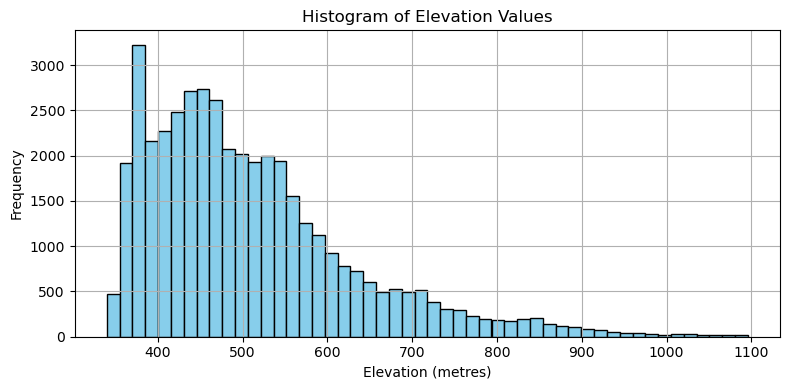

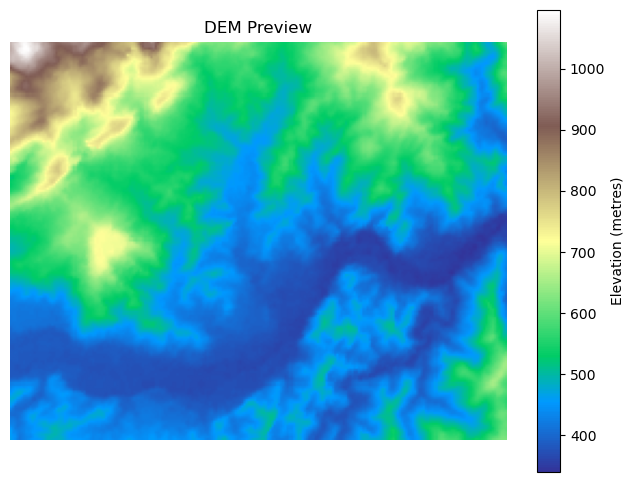

In [108]:
# Open the raster file safely using a context manager
# This ensures the file is automatically closed after the block finishes
with rasterio.open(dem_path) as src:
    
    # Read the first band of the raster (DEM values are stored in the first band)
    dem_data = src.read(1)

    # Display basic metadata about the raster ---
    print("Raster dimensions (rows, cols):", dem_data.shape)        # Size of the raster in pixels
    print("Number of bands:", src.count)                             # Number of raster bands (should be 1 for a DEM)
    print("Coordinate reference system (CRS):", src.crs)            # The spatial reference system
    print("Resolution (pixel size):", src.res)                      # Pixel resolution in spatial units (e.g. metres)
    print("Data type:", dem_data.dtype)                             # Data type of the pixel values (e.g. float32, int16)
    print("Min / Max elevation:", np.nanmin(dem_data), "/", np.nanmax(dem_data))  # Elevation range, ignoring NaNs

    #  Create a histogram to visualise the distribution of elevation values ---
    plt.figure(figsize=(8, 4))
    plt.hist(
        dem_data[~np.isnan(dem_data)].flatten(),  # Flatten the array and exclude NaN values
        bins=50,
        color='skyblue',
        edgecolor='black'
    )
    plt.title("Histogram of Elevation Values")
    plt.xlabel("Elevation (metres)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Display the DEM as an image using a colour scale ---
    plt.figure(figsize=(8, 6))
    plt.imshow(dem_data, cmap='terrain')            # Apply a terrain colourmap
    plt.colorbar(label="Elevation (metres)")        # Add a colourbar for elevation
    plt.title("DEM Preview")                        # Plot title
    plt.axis("off")                                 # Hide axis ticks and labels
    plt.show()


### 4.3 Exploring raster metadata with `.meta`

When working with raster data in Python using `rasterio`, each raster file contains the metadata that describes its structure and spatial properties. The `.meta` attribute provides a dictionary summarising key metadata fields of the raster file. 
src_dem.meta returns a dictionary with key properties of the raster dataset. 


In [110]:
src_dem.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 230,
 'height': 185,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002694945852358564, 0.0, -73.19808728699282,
        0.0, -0.0002694945852358564, 4.8553483741722445)}

####  Understanding `transform` 

To accurately place a raster in geographic space, it is not enough to know just the Coordinate Reference System (CRS). We must also define:

- the **origin** of the raster: the coordinates of the upper-left corner (`x_min`, `y_max`), and  
- the **pixel resolution**: width and height of each cell (`delta_x`, `delta_y`).

In `rasterio`, these values are stored using an **affine transformation matrix**. 

Note that, by convention, the **origin of the raster y-axis** is set to the **maximum value (`y_max`)** rather than the minimum.

As a result, the **y-axis resolution (`delta_y`) is negative**. It reflects the way raster images are stored: the origin is in the **top-left corner**, and moving **downward** along the rows corresponds to **decreasing y-values**.




### ✏️ Now it’s your turn – Understanding raster metadata

Now, your task is to explain in your own words what the other elements of the raster metadata mean